Camembert est un modèle NLP qui permet le traitement du texte des retours clients en français suite à une enquête de satisfaction, et classer leurs retours selon les problématiques roncontrées qu'ils ont roncontrés.

In [ ]:
# Vérifier si un GPU est disponible et l'afficher
import torch
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("Pas de GPU disponible, le script s'exécutera sur CPU.")
    device = torch.device("cpu")

GPU disponible: Tesla T4


In [ ]:
!pip install -U transformers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import CamembertTokenizer, CamembertForSequenceClassification, TrainingArguments, Trainer
from transformers import logging as hf_logging
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier # Import pour la baseline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import random

# **1 - Préparation et nettoyage des données**

In [ ]:
df = pd.read_excel("Verbatims.xlsx")
df.head()

In [ ]:
nb_labels_uniques = df["Motif"].nunique()
print(f"Nombre de labels uniques : {nb_labels_uniques}")
print("Taille du jeu de données :", df.shape)
display("Labels uniques :", sorted(df["Motif"].unique()))
df.info()

In [ ]:
# Supprimer les lignes où 'text' ou 'label' sont vides ou NaN ou espaces
df = df.dropna(subset=["Motif", "Verbatims"])  # supprime lignes avec NaN dans text ou label

# Supprimer lignes où 'text' ou 'label' sont des chaînes vides ou uniquement espaces
df = df[df["Motif"].str.strip() != ""]
df = df[df["Verbatims"].str.strip() != ""]

# Mettre en minuscules dans les deux colonnes
df["Motif"] = df["Motif"].str.lower()
df["Verbatims"] = df["Verbatims"].str.lower()

df["nb_mots"] = df["Motif"].astype(str).apply(lambda x: len(x.split()))

print(f"Nombre null de texte et label :", df[["Motif", "Verbatims"]].isnull().sum())

Nombre null de texte et label : Motif        0
Verbatims    0
dtype: int64


In [ ]:
# Calculer le nombre de mots pour chaque commentaire
df["nb_mots"] = df["Verbatims"].str.split().str.len()

# Grouper par 'Motif' et calculer les statistiques
mots_par_label = df.groupby("Motif")["nb_mots"].agg([
    ("nb_commentaires", "count"),
    ("nb_total_mots", "sum"),
    ("nb_mots_max", "max"),
    ("nb_mots_min","min"),
    ("moyenne_mots","mean")
]).sort_values(by="nb_commentaires", ascending=False)

# Afficher le résultat
print("\nAnalyse par label :")
print(mots_par_label)


Analyse par label :
                       nb_commentaires  nb_total_mots  nb_mots_max  \
Motif                                                                
délai / non livré                11416         353931         1701   
abîmé                             3484         100439          311   
relation client                   1512          68930          766   
offre commerciale                 1288          61001          475   
procédure retrait                 1082          53879          599   
disponibilité produit             1004          50150          426   
2e vie / défectueux               1002          39957          495   
inversion                          964          33894          327   
anomalie colis                     839          26794          366   
manquant                           731          23587          432   
qualité de service                 518          22114          301   
emballage inadapté                 506          19574          388   

# **2 - Filtrage et encodage des labels**

In [ ]:
# --- 4. Configuration des Noms de Colonnes et Paramètres de Filtrage ---
text_column = 'Verbatims'
labels_column = 'Motif'
MAX_TEXT_CHAR_LENGTH = 512  # Longueur maximale des caractères du verbatim
MAX_SAMPLES_PER_LABEL = 1000 # Nombre maximum de verbatims par motif

In [ ]:
# Assurez-vous que la colonne 'Motif' est bien une liste de chaînes, pas une chaîne représentant une liste
print(f"\nVérification et conversion de la colonne '{labels_column}' en listes réelles...")
def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            evaluated = ast.literal_eval(x)
            if isinstance(evaluated, list) and all(isinstance(item, str) for item in evaluated):
                return evaluated
            else:
                if isinstance(evaluated, str):
                    return [evaluated]
                return []
        except (ValueError, SyntaxError):
            return [x.strip()]
    elif isinstance(x, list):
        return [str(item) for item in x]
    return []

df[labels_column] = df[labels_column].apply(safe_literal_eval)


Vérification et conversion de la colonne 'Motif' en listes réelles...


In [ ]:
# Filtrer les lignes sans motifs valides après traitement
original_rows_after_eval = len(df)
df = df[df[labels_column].apply(len) > 0].reset_index(drop=True)
print(f"Filtré {original_rows_after_eval - len(df)} lignes sans motifs valides après conversion. Nouvelle taille : {len(df)}")

Filtré 0 lignes sans motifs valides après conversion. Nouvelle taille : 27540


In [ ]:
# Filtrage par longueur de texte ---
print(f"\nFiltrage des verbatims avec un texte de moins de {MAX_TEXT_CHAR_LENGTH} caractères...")
df['text_length'] = df[text_column].astype(str).apply(len)
initial_count_after_label_filter = len(df)
df = df[df['text_length'] <= MAX_TEXT_CHAR_LENGTH].reset_index(drop=True)
print(f"Filtré {initial_count_after_label_filter - len(df)} verbatims trop longs (>{MAX_TEXT_CHAR_LENGTH} caractères). Nouvelle taille : {len(df)}")
df = df.drop(columns=['text_length']) # Nettoyer la colonne temporaire


Filtrage des verbatims avec un texte de moins de 512 caractères...
Filtré 1858 verbatims trop longs (>512 caractères). Nouvelle taille : 25682


In [ ]:
# 7. Encodage des Labels Multi-Label (One-Hot Encoding) ---
print("\nEncodage des labels multi-label (One-Hot Encoding)...")

mlb = MultiLabelBinarizer()
mlb.fit(df[labels_column])

labels_encoded = mlb.transform(df[labels_column])
df['labels_encoded'] = list(labels_encoded)

all_labels = mlb.classes_
print(f"Motifs uniques détectés : {list(all_labels)}")
print(f"Nombre de motifs uniques : {len(all_labels)}")
NUM_LABELS = len(all_labels)


Encodage des labels multi-label (One-Hot Encoding)...
Motifs uniques détectés : ['2e vie / défectueux', 'abîmé', 'anomalie colis', 'autres sujets', 'cadeau', 'description produit', 'disponibilité produit', 'données client', 'doublon commande', 'délai / non livré', 'emballage inadapté', 'inversion', 'manquant', 'offre commerciale', 'paiement', 'procédure retrait', 'qualité de service', 'relation client', 'retour', 'sav', 'scindage', 'sollicitation client', 'suivi commande']
Nombre de motifs uniques : 23


In [ ]:
# 8. Sélection aléatoire de 1000 verbatims par motif ---
print(f"\nSélection aléatoire d'un maximum de {MAX_SAMPLES_PER_LABEL} verbatims par motif...")

selected_indices = set() # Utiliser un set pour éviter les doublons d'indices

for i, label_name in enumerate(all_labels):
    # Trouver les indices des verbatims qui contiennent ce motif
    indices_for_label = [idx for idx, label_vec in enumerate(labels_encoded) if label_vec[i] == 1]

    if len(indices_for_label) > MAX_SAMPLES_PER_LABEL:
        selected_for_this_label = random.sample(indices_for_label, MAX_SAMPLES_PER_LABEL)
        print(f"  Motif '{label_name}': {len(indices_for_label)} verbatims trouvés, sélection de {MAX_SAMPLES_PER_LABEL}.")
    else:
        selected_for_this_label = indices_for_label
        print(f"  Motif '{label_name}': {len(indices_for_label)} verbatims trouvés, sélection de {len(indices_for_label)} (inférieur ou égal à {MAX_SAMPLES_PER_LABEL}).")

    selected_indices.update(selected_for_this_label) # Ajouter les indices au set global


Sélection aléatoire d'un maximum de 1000 verbatims par motif...
  Motif '2e vie / défectueux': 902 verbatims trouvés, sélection de 902 (inférieur ou égal à 1000).
  Motif 'abîmé': 3339 verbatims trouvés, sélection de 1000.
  Motif 'anomalie colis': 803 verbatims trouvés, sélection de 803 (inférieur ou égal à 1000).
  Motif 'autres sujets': 285 verbatims trouvés, sélection de 285 (inférieur ou égal à 1000).
  Motif 'cadeau': 134 verbatims trouvés, sélection de 134 (inférieur ou égal à 1000).
  Motif 'description produit': 338 verbatims trouvés, sélection de 338 (inférieur ou égal à 1000).
  Motif 'disponibilité produit': 875 verbatims trouvés, sélection de 875 (inférieur ou égal à 1000).
  Motif 'données client': 266 verbatims trouvés, sélection de 266 (inférieur ou égal à 1000).
  Motif 'doublon commande': 140 verbatims trouvés, sélection de 140 (inférieur ou égal à 1000).
  Motif 'délai / non livré': 10877 verbatims trouvés, sélection de 1000.
  Motif 'emballage inadapté': 475 verbat

In [ ]:
# Créer un nouveau DataFrame avec seulement les verbatims sélectionnés
df_filtered = df.iloc[list(selected_indices)].reset_index(drop=True)
print(f"Nombre total de verbatims après filtrage par longueur et sélection par motif : {len(df_filtered)}")

# Le DataFrame à utiliser pour la suite est maintenant df_filtered
df = df_filtered

Nombre total de verbatims après filtrage par longueur et sélection par motif : 12976


In [ ]:
# Calculer le nombre de mots pour chaque commentaire
df["nb_mots"] = df["Verbatims"].str.split().str.len()

# Grouper par 'Motif' et calculer les statistiques
mots_par_label = df.groupby("Motif")["nb_mots"].agg([
    ("nb_commentaires", "count"),
    ("nb_total_mots", "sum"),
    ("nb_mots_max", "max"),
    ("nb_mots_min","min"),
    ("moyenne_mots","mean")
]).sort_values(by="nb_commentaires", ascending=False)

# Afficher le résultat
print("\nAnalyse par label :")
print(mots_par_label)

In [ ]:
#  Analyse des statistiques après filtrage (optionnel) ---
print("\n--- Analyse des statistiques par label après filtrage et échantillonnage ---")
# Recalculer le nombre de mots pour l'analyse après le filtrage final
df["nb_mots"] = df[text_column].astype(str).str.split().str.len()
label_counts = pd.Series(np.concatenate(df[labels_column])).value_counts()
print("\nNombre d'occurrences de chaque motif après filtrage :")
print(label_counts.to_string())


--- Analyse des statistiques par label après filtrage et échantillonnage ---

Nombre d'occurrences de chaque motif après filtrage :
abîmé                    1000
relation client          1000
offre commerciale        1000
délai / non livré        1000
procédure retrait         929
inversion                 907
2e vie / défectueux       902
disponibilité produit     875
anomalie colis            803
manquant                  697
qualité de service        479
emballage inadapté        475
sollicitation client      378
suivi commande            375
paiement                  359
description produit       338
retour                    322
autres sujets             285
données client            266
sav                       237
doublon commande          140
cadeau                    134
scindage                   75


# **3 - Split des données (Entrainement, validation et test)**

In [ ]:
# 9. Division des Données ---
print("\nDivision des données (entraînement, validation, test)...")
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Taille de l'ensemble d'entraînement : {len(train_df)}")
print(f"Taille de l'ensemble de validation : {len(val_df)}")
print(f"Taille de l'ensemble de test : {len(test_df)}")


Division des données (entraînement, validation, test)...
Taille de l'ensemble d'entraînement : 9083
Taille de l'ensemble de validation : 1946
Taille de l'ensemble de test : 1947


In [ ]:
# Extraire les labels encodés pour l'entraînement de la baseline
y_true_train = np.array(train_df['labels_encoded'].tolist())
y_true_test = np.array(test_df['labels_encoded'].tolist())

# **4 - la Tokinisation**

In [ ]:
# 10. Tokenisation et Création du Dataset ---
print("\nInitialisation du tokeniseur CamemBERT et création du Dataset...")

tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

class MultiLabelTextClassificationDataset(Dataset):
    def __init__(self, texts, labels_encoded, tokenizer, max_len):
        self.texts = texts
        self.labels_encoded = labels_encoded
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels_encoded[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

MAX_LEN = 512 # La longueur maximale des tokens pour CamemBERT.

train_dataset = MultiLabelTextClassificationDataset(
    texts=train_df[text_column].tolist(),
    labels_encoded=train_df['labels_encoded'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = MultiLabelTextClassificationDataset(
    texts=val_df[text_column].tolist(),
    labels_encoded=val_df['labels_encoded'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = MultiLabelTextClassificationDataset(
    texts=test_df[text_column].tolist(),
    labels_encoded=test_df['labels_encoded'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Exemple d'encodage (input_ids) : {train_dataset[0]['input_ids']}")
print(f"Exemple de labels encodés : {train_dataset[0]['labels']}")


Initialisation du tokeniseur CamemBERT et création du Dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Exemple d'encodage (input_ids) : tensor([    5,   173,    19, 14266,    45,    56,    34,   237,  4889,   106,
          136,   971,     8,  8432,   573,     6,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,   

# **5 - Configuration et entrainement du modèle**

In [ ]:
# 11. Chargement du Modèle et Définition des Métriques ---
print("\nChargement du modèle CamemBERT pour la classification multi-label...")

model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=NUM_LABELS)
model.to(device) # Déplacer le modèle sur le GPU si disponible

def compute_metrics_multi_label(p):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    y_pred = (torch.sigmoid(torch.from_numpy(logits)) > 0.5).int().numpy() # Fix: .astype(int)
    y_true = p.label_ids

    accuracy = accuracy_score(y_true, y_pred)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
    }


Chargement du modèle CamemBERT pour la classification multi-label...


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 12. Configuration de l'Entraînement (Fine-tuning) ---
print("\nConfiguration de l'entraînement...")

training_args = TrainingArguments(
    output_dir='./results_multilabel',
    num_train_epochs=10, # À ajuster selon la taille de votre dataset et vos ressources
    per_device_train_batch_size=4, # Plus petit batch size si vous avez des problèmes de mémoire GPU
    per_device_eval_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs_multilabel',
    logging_steps=10,
    eval_strategy="epoch", # Fix: 'eval_strategy' au lieu de 'evaluation_strategy'
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro", # Ou f1_micro, selon vos priorités
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multi_label,
)


Configuration de l'entraînement...


In [ ]:
# --- 13. Entraînement du Modèle CamemBERT ---
print("\nEntraînement du modèle CamemBERT (fine-tuning multi-label)...")
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



Entraînement du modèle CamemBERT (fine-tuning multi-label)...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a7hmed0777 (a7hmed0777-paris-school-of-business) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro
1,0.101600,0.092908,0.419836,0.551096,0.801766,0.419836,0.282438,0.315116,0.260642
2,0.074500,0.069694,0.698869,0.733316,0.759780,0.708633,0.617133,0.671615,0.595683
3,0.041500,0.066514,0.727646,0.751586,0.773667,0.730730,0.663354,0.738037,0.651772
4,0.026200,0.062996,0.755396,0.779180,0.797632,0.761562,0.713674,0.762687,0.686412
5,0.013600,0.067805,0.770812,0.785862,0.789119,0.782631,0.746424,0.765094,0.740001
6,0.015400,0.068571,0.778006,0.792228,0.798851,0.785714,0.760772,0.775557,0.752911
7,0.005500,0.071369,0.782117,0.792821,0.791198,0.794450,0.765078,0.768213,0.766070
8,0.003100,0.073859,0.783145,0.796497,0.798554,0.794450,0.765180,0.762835,0.770286
9,0.013100,0.076965,0.786228,0.796187,0.798450,0.793936,0.763590,0.769057,0.762009
10,0.001700,0.076748,0.787770,0.799175,0.801862,0.796506,0.766876,0.770294,0.765940


TrainOutput(global_step=22710, training_loss=0.037682806580433666, metrics={'train_runtime': 3801.3883, 'train_samples_per_second': 23.894, 'train_steps_per_second': 5.974, 'total_flos': 2.390288320994304e+16, 'train_loss': 0.037682806580433666, 'epoch': 10.0})

# **6 - Evaluation du Modèle**

In [ ]:
# --- 14. Évaluation du Modèle CamemBERT sur l'Ensemble de Test ---
print("\nÉvaluation du modèle CamemBERT sur l'ensemble de test...")
results = trainer.evaluate(test_dataset)
print(f"Résultats d'évaluation du modèle CamemBERT : {results}")

predictions = trainer.predict(test_dataset)
logits_test = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions
y_pred_proba = torch.sigmoid(torch.from_numpy(logits_test)).numpy()
y_pred_binary = (y_pred_proba > 0.5).astype(int) # Fix: .astype(int)


Évaluation du modèle CamemBERT sur l'ensemble de test...


Résultats d'évaluation du modèle CamemBERT : {'eval_loss': 0.07630081474781036, 'eval_accuracy': 0.7919876733436055, 'eval_f1_micro': 0.8036082474226804, 'eval_precision_micro': 0.8065183652353854, 'eval_recall_micro': 0.8007190549563431, 'eval_f1_macro': 0.773517715896176, 'eval_precision_macro': 0.7750994491702616, 'eval_recall_macro': 0.7866296865979543, 'eval_runtime': 17.8179, 'eval_samples_per_second': 109.272, 'eval_steps_per_second': 27.332, 'epoch': 10.0}



--- Affichage des courbes d'évolution ---


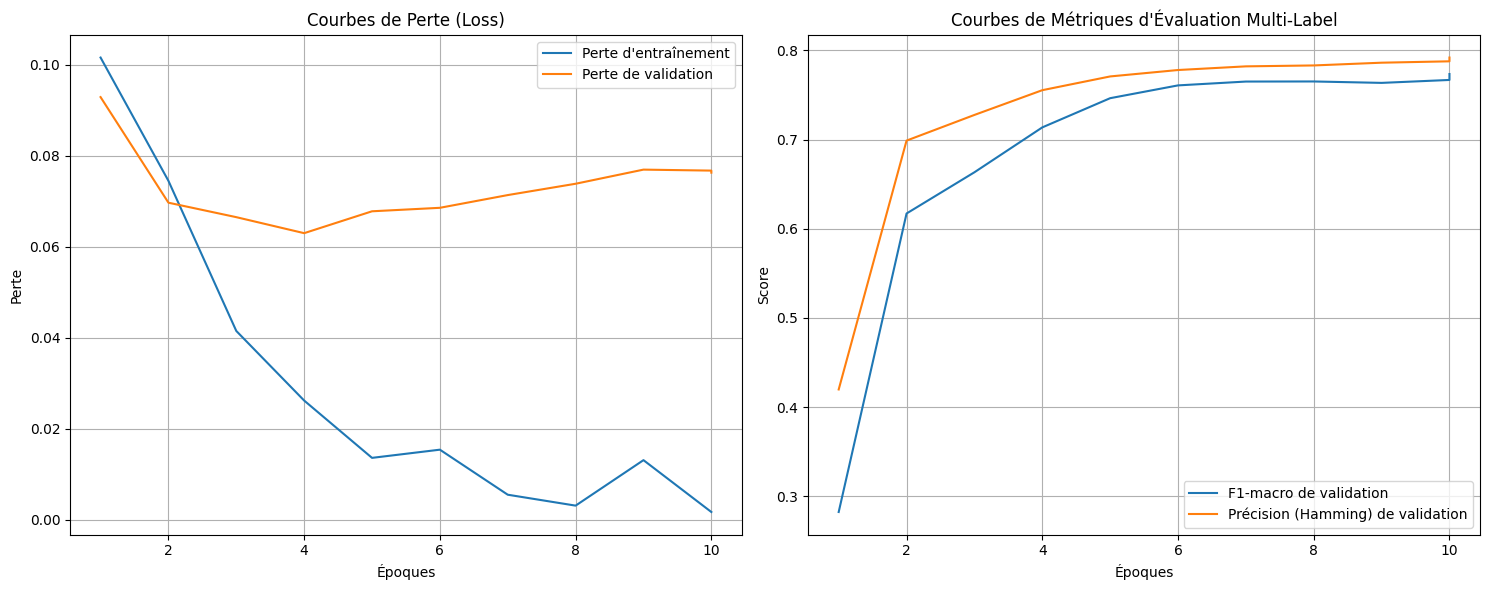

In [ ]:
# --- 15. Affichage des Courbes d'Évolution (Perte et Métriques) ---
print("\n--- Affichage des courbes d'évolution ---")

log_history = trainer.state.log_history

eval_epochs = []
eval_losses_for_plot = []
eval_f1_macro_for_plot = []
eval_accuracy_for_plot = []
train_losses_for_plot = []

last_train_loss_in_epoch = None

for entry in log_history:
    if 'loss' in entry and 'eval_loss' not in entry:
        last_train_loss_in_epoch = entry['loss']
    if 'eval_loss' in entry and 'epoch' in entry:
        eval_epochs.append(entry['epoch'])
        eval_losses_for_plot.append(entry['eval_loss'])
        eval_f1_macro_for_plot.append(entry['eval_f1_macro'])
        eval_accuracy_for_plot.append(entry['eval_accuracy'])
        if last_train_loss_in_epoch is not None:
            train_losses_for_plot.append(last_train_loss_in_epoch)
            last_train_loss_in_epoch = None
        else:
            train_losses_for_plot.append(np.nan)

# Ensure lengths match for plotting the losses
min_len = min(len(train_losses_for_plot), len(eval_losses_for_plot))
train_losses_for_plot = train_losses_for_plot[:min_len]
eval_losses_for_plot = eval_losses_for_plot[:min_len]
epochs_for_plot = eval_epochs[:min_len]


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_for_plot, train_losses_for_plot, label='Perte d\'entraînement')
plt.plot(epochs_for_plot, eval_losses_for_plot, label='Perte de validation')
plt.title('Courbes de Perte (Loss)')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_for_plot, eval_f1_macro_for_plot, label='F1-macro de validation')
plt.plot(epochs_for_plot, eval_accuracy_for_plot, label='Précision (Hamming) de validation')
plt.title('Courbes de Métriques d\'Évaluation Multi-Label')
plt.xlabel('Époques')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 16. Analyse des Métriques par Label (Tableau) ---
print("\n--- Métriques par Label (Multi-Label) ---")

metrics_per_label_dict = {}
for i, label_name in enumerate(all_labels):
    precision_l, recall_l, f1_l, _ = precision_recall_fscore_support(y_true_test[:, i], y_pred_binary[:, i], average='binary', zero_division=0)
    metrics_per_label_dict[label_name] = {
        'Precision': precision_l,
        'Recall': recall_l,
        'F1-Score': f1_l
    }

metrics_df = pd.DataFrame.from_dict(metrics_per_label_dict, orient='index')
metrics_df.index.name = 'Motif'
print(metrics_df.to_string())


--- Métriques par Label (Multi-Label) ---
                       Precision    Recall  F1-Score
Motif                                               
2e vie / défectueux     0.891473  0.884615  0.888031
abîmé                   0.901961  0.878981  0.890323
anomalie colis          0.833333  0.818966  0.826087
autres sujets           0.777778  0.666667  0.717949
cadeau                  0.812500  1.000000  0.896552
description produit     0.750000  0.857143  0.800000
disponibilité produit   0.732143  0.872340  0.796117
données client          0.704545  0.794872  0.746988
doublon commande        0.703704  0.826087  0.760000
délai / non livré       0.797203  0.703704  0.747541
emballage inadapté      0.661972  0.758065  0.706767
inversion               0.897436  0.846774  0.871369
manquant                0.774775  0.819048  0.796296
offre commerciale       0.857143  0.818182  0.837209
paiement                0.735849  0.750000  0.742857
procédure retrait       0.797203  0.820144  0.808511
qua


--- Matrices de Confusion Binaires par Label ---


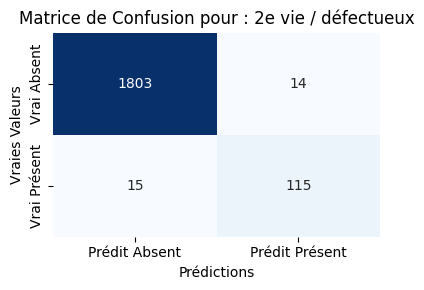

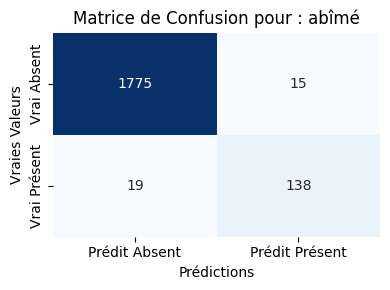

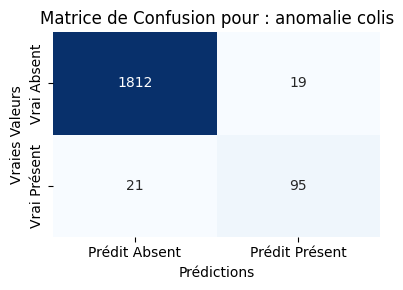

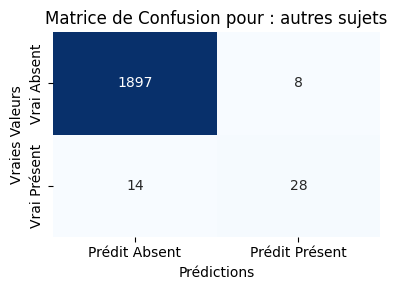

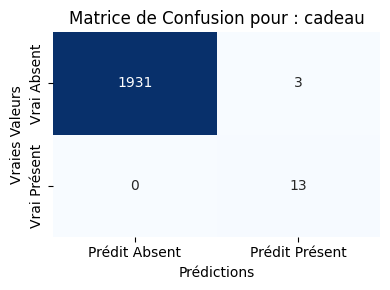

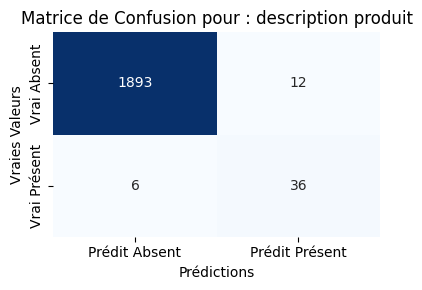

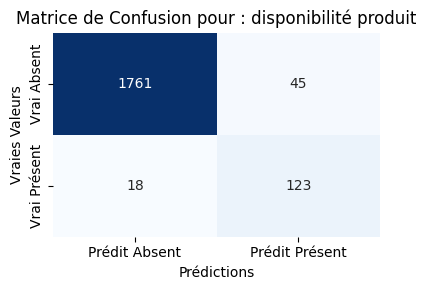

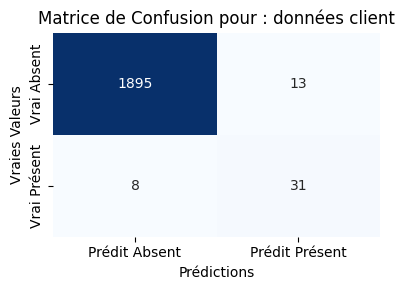

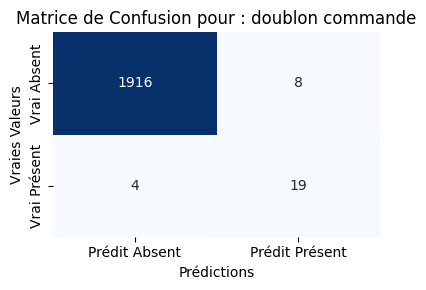

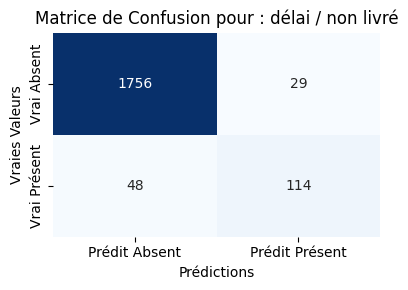

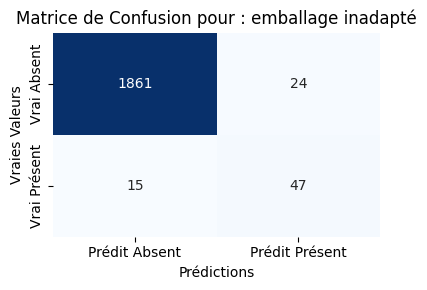

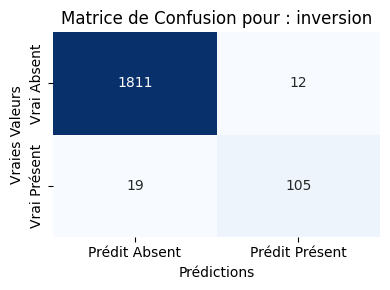

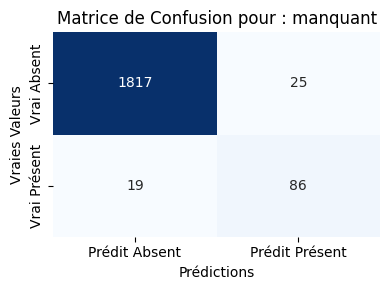

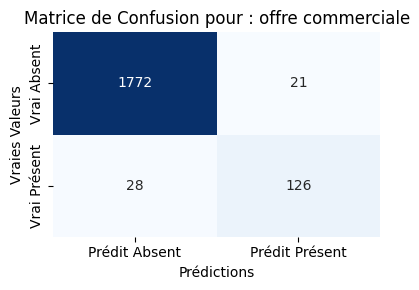

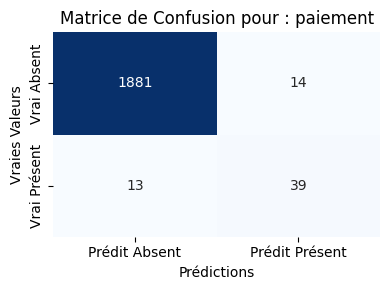

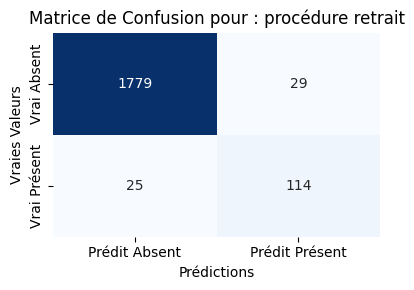

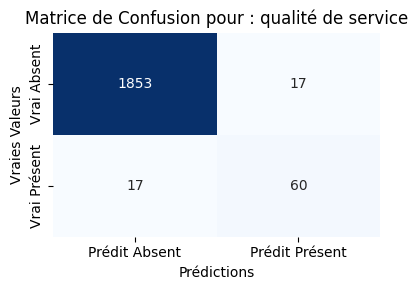

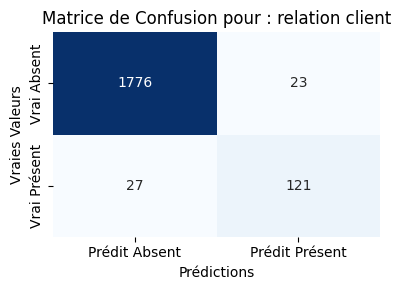

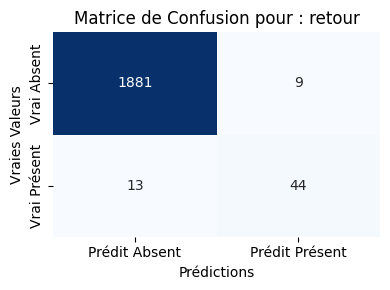

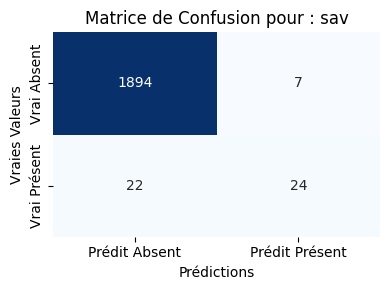

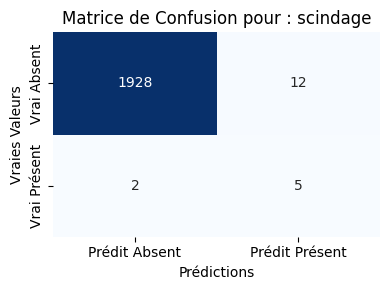

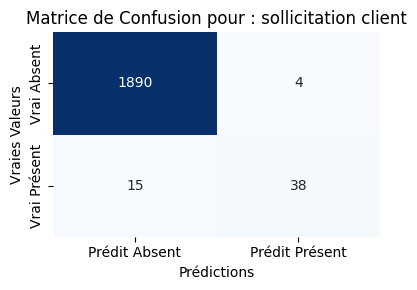

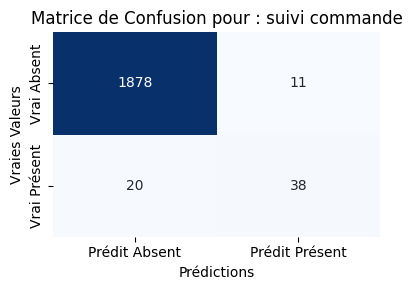

In [ ]:
from sklearn.metrics import confusion_matrix
# --- 17. Analyse des Confusions (Matrices Binaires par Label) ---
print("\n--- Matrices de Confusion Binaires par Label ---")

for i, label_name in enumerate(all_labels):
    y_true_label = y_true_test[:, i]
    y_pred_label = y_pred_binary[:, i]

    cm = confusion_matrix(y_true_label, y_pred_label)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Prédit Absent', 'Prédit Présent'],
                yticklabels=['Vrai Absent', 'Vrai Présent'])
    plt.title(f'Matrice de Confusion pour : {label_name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies Valeurs')
    plt.tight_layout()
    plt.show()

In [ ]:
# Créer un DataFrame pour faciliter l'analyse des erreurs
errors_df = pd.DataFrame(columns=['Motif_Manquant', 'Motif_Prédit_Incorrectement', 'Type_Erreur', 'Count'])

error_data = []

# Parcourir chaque échantillon dans l'ensemble de test
for sample_idx in range(len(y_true_test)):
    true_labels_idx = np.where(y_true_test[sample_idx] == 1)[0]
    pred_labels_idx = np.where(y_pred_binary[sample_idx] == 1)[0]

    # Convertir les indices en noms de labels
    true_label_names = [all_labels[j] for j in true_labels_idx]
    pred_label_names = [all_labels[j] for j in pred_labels_idx]

    # Détecter les Faux Positifs (le modèle a prédit X mais X n'est pas un vrai label)
    for pred_lbl in pred_label_names:
        if pred_lbl not in true_label_names:
            # C'est un FP. Quels sont les vrais labels manquants qui auraient pu causer cette confusion ?
            # Ou quels sont les vrais labels présents avec lesquels il y a confusion ?
            # Pour une matrice de confusion classique, nous ne cherchons pas "ce qui aurait pu être".
            # Ici, nous pouvons simplement noter le FP.
            error_data.append({'Motif_Manquant': 'AUCUN', # Pour un FP, aucun n'est vraiment 'manquant'
                               'Motif_Prédit_Incorrectement': pred_lbl,
                               'Type_Erreur': 'Faux Positif'})

    # Détecter les Faux Négatifs (un vrai label est Y mais le modèle n'a pas prédit Y)
    for true_lbl in true_label_names:
        if true_lbl not in pred_label_names:
            # C'est un FN. Quelles sont les prédictions incorrectes qui ont été faites à la place ?
            # Ou quels sont les labels que le modèle a prédit (qui ne sont pas des vrais)
            # qui pourraient être la source de la confusion ?
            if len(pred_label_names) > 0:
                for incorrect_pred_lbl in pred_label_names: # Les labels qu'il a prédits
                    error_data.append({'Motif_Manquant': true_lbl,
                                       'Motif_Prédit_Incorrectement': incorrect_pred_lbl,
                                       'Type_Erreur': 'Faux Négatif et Confusion'})
            else: # Si aucun label n'a été prédit du tout
                error_data.append({'Motif_Manquant': true_lbl,
                                   'Motif_Prédit_Incorrectement': 'AUCUN',
                                   'Type_Erreur': 'Faux Négatif'})

if error_data:
    errors_df = pd.DataFrame(error_data)

    # Créer une matrice de co-occurrence pour les confusions de Faux Négatifs
    print("\n--- Matrice de Co-occurrence des Faux Négatifs ---")
    # Cette matrice montre "Quand le motif X est vrai mais manquant, quel autre motif Y a été prédit ?"
    fn_confusion_matrix = pd.crosstab(
        errors_df[errors_df['Type_Erreur'].isin(['Faux Négatif', 'Faux Négatif et Confusion'])]['Motif_Manquant'],
        errors_df[errors_df['Type_Erreur'].isin(['Faux Négatif', 'Faux Négatif et Confusion'])]['Motif_Prédit_Incorrectement'],
        dropna=False # Important pour inclure les combinaisons sans erreurs
    )
    # S'assurer que tous les labels sont dans les colonnes/index, même s'ils n'ont pas d'erreurs
    # Re-indexer pour inclure tous les all_labels comme index et colonnes
    fn_confusion_matrix = fn_confusion_matrix.reindex(index=all_labels, columns=all_labels, fill_value=0)
    # Ajouter une colonne 'AUCUN' pour les FN sans prédiction associée
    if 'AUCUN' in fn_confusion_matrix.columns:
        # Move 'AUCUN' to the end for better visualization if it exists
        cols = [col for col in fn_confusion_matrix.columns if col != 'AUCUN'] + ['AUCUN']
        fn_confusion_matrix = fn_confusion_matrix[cols]
    print(fn_confusion_matrix.to_string())

    plt.figure(figsize=(len(all_labels)+2, len(all_labels)+2))
    sns.heatmap(fn_confusion_matrix, annot=True, fmt='d', cmap='YlOrRd', linewidths=.5)
    plt.title('Confusions (Faux Négatifs): Vrai Label vs. Label Prédit Incorrectement')
    plt.xlabel('Label Prédit Incorrectement')
    plt.ylabel('Vrai Label Manquant')
    plt.tight_layout()
    plt.show()

    # Créer une matrice de co-occurrence pour les confusions de Faux Positifs
    print("\n--- Matrice de Co-occurrence des Faux Positifs ---")
    # Ici, nous comptons juste les FP par motif prédit.
    fp_counts = errors_df[errors_df['Type_Erreur'] == 'Faux Positif']['Motif_Prédit_Incorrectement'].value_counts().sort_index()
    fp_counts = fp_counts.reindex(all_labels, fill_value=0)
    print("Nombre de Faux Positifs par motif prédit :")
    print(fp_counts.to_string())

else:
    print("Aucune erreur de classification détectée pour la co-occurrence des confusions.")

In [ ]:
# 18. Analyse des Exemples Mal Classifiés (Optionnel) ---
print("\n Exemples de Verbatims mal classifiés ")
num_examples_to_show = 20
wrong_predictions_count = 0

test_df_with_preds = test_df.copy()
test_df_with_preds['y_true_encoded'] = list(y_true_test)
test_df_with_preds['y_pred_encoded'] = list(y_pred_binary)

for idx, row in test_df_with_preds.iterrows():
    true_labels_binary = row['y_true_encoded']
    pred_labels_binary = row['y_pred_encoded']

    if not np.array_equal(true_labels_binary, pred_labels_binary):
        wrong_predictions_count += 1
        if wrong_predictions_count <= num_examples_to_show:
            print(f"\nVerbatim : {row[text_column]}")

            true_labels = [all_labels[j] for j, val in enumerate(true_labels_binary) if val == 1]
            pred_labels = [all_labels[j] for j, val in enumerate(pred_labels_binary) if val == 1]

            false_positives = [lbl for lbl in pred_labels if lbl not in true_labels]
            false_negatives = [lbl for lbl in true_labels if lbl not in pred_labels]

            print(f"  Vrais Labels : {true_labels}")
            print(f"  Labels Prédits : {pred_labels}")
            if false_positives:
                print(f"  Faux Positifs : {false_positives}")
            if false_negatives:
                print(f"  Faux Négatifs : {false_negatives}")

if wrong_predictions_count > num_examples_to_show:
    print(f"\n... et {wrong_predictions_count - num_examples_to_show} autres exemples mal classifiés.")
elif wrong_predictions_count == 0:
    print("Aucun exemple mal classifié détecté sur l'ensemble de test (ce qui est très rare !).")